load the huggingface model, dinov2 uses patches so mean pool token embeddings into single vector, then use L2 norm so we can do cosine similarity with faiss


In [12]:
import torch
import os
import pandas as pd
import json
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from tqdm import tqdm

# Set up MPS device if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal) device")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")

def get_image_embedding(image_path, processor, model):
    """
    Given an image file path, returns a single, L2-normalized embedding vector.
    """
    try:
        image = Image.open(image_path).convert("RGB").resize((224, 224))
        inputs = processor(images=image, return_tensors="pt", padding=True)
        
        # Move inputs to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        token_embeddings = outputs.last_hidden_state.squeeze(0)
        pooled_embedding = token_embeddings.mean(dim=0)
        normalized_embedding = pooled_embedding / pooled_embedding.norm(p=2)
        return normalized_embedding
    except Exception as e:
        print(f"❌ Error processing image {image_path}: {e}")
        return None

# Initialize model and processor
print("Initializing model and processor...")
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model = model.to(device)  # Move model to MPS device
model.eval()

# Rest of your code remains the same...
print("Loading CSV...")
csv_path = "/Users/adamgeorghiou/dino_v2_ann/pokemon.csv"
df = pd.read_csv(csv_path)
print("CSV loaded with", len(df), "rows")

images_dir = "/Users/adamgeorghiou/dino_v2_ann/images"
embeddings_list = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
    name = row['Name']
    possible_files = [f"{name}.jpg", f"{name}.jpeg", f"{name}.png"]
    image_path = None
    
    for file in possible_files:
        candidate = os.path.join(images_dir, file)
        if os.path.exists(candidate):
            image_path = candidate
            break
            
    if image_path is None:
        print(f"\nImage for '{name}' not found.")
        embeddings_list.append(None)
    else:
        try:
            embedding = get_image_embedding(image_path, processor, model)
            if embedding is not None:
                embedding_list = embedding.cpu().numpy().tolist()
                embeddings_list.append(embedding_list)
            else:
                embeddings_list.append(None)
        except Exception as e:
            print(f"\nError processing {name}: {e}")
            embeddings_list.append(None)

print("\nSaving results...")
df["embedding"] = embeddings_list
df["embedding_str"] = df["embedding"].apply(lambda x: json.dumps(x) if x is not None else "")

output_csv_path = "/Users/adamgeorghiou/dino_v2_ann/pokemon_with_embeddings.csv"
df.to_csv(output_csv_path, index=False)
print("✅ Embeddings saved to", output_csv_path)

/Users/adamgeorghiou/dino_v2_ann/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS (Metal) device
Initializing model and processor...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CSV...
CSV loaded with 809 rows


Processing images:   0%|          | 0/809 [00:00<?, ?it/s]/Users/adamgeorghiou/dino_v2_ann/.venv/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `BitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Processing images: 100%|██████████| 809/809 [00:47<00:00, 16.95it/s]



Saving results...
✅ Embeddings saved to /Users/adamgeorghiou/dino_v2_ann/pokemon_with_embeddings.csv


when embeddings are saved -> we can now run ann using faiss, we find the approx near neighbour, can use knn for exact distance with small dataset, with faiss can play around with this line 'ndex = faiss.IndexFlatIP(embedding_dim)" for different index types check docs. f

Embeddings shape: (809, 768)
Number of embeddings in index: 809
Top-k search results:
Rank 1: Name = electrode, Distance = 1.000000238418579
Rank 2: Name = voltorb, Distance = 0.9473824501037598
Rank 3: Name = munna, Distance = 0.919330894947052


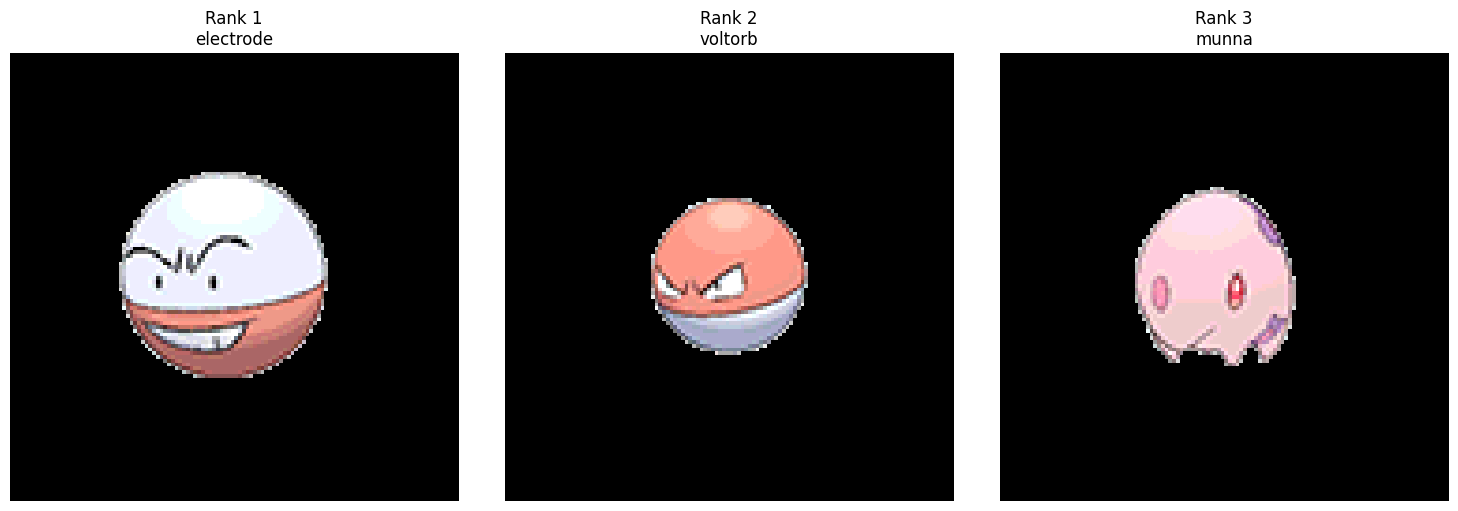

In [2]:
import os
import numpy as np
import pandas as pd
import json
import faiss
import matplotlib.pyplot as plt
from PIL import Image

# load csv
csv_path = "/Users/adamgeorghiou/dino_v2_ann/pokemon_with_embeddings.csv"
df = pd.read_csv(csv_path)

def decode_embedding(emb_str):
    return json.loads(emb_str) if emb_str and isinstance(emb_str, str) else None

df['embedding'] = df['embedding_str'].apply(decode_embedding)
df_embeddings = df[df['embedding'].notnull()].copy()

# stack embeddings as numpy array
embeddings = np.array(df_embeddings['embedding'].tolist(), dtype=np.float32)
print("Embeddings shape:", embeddings.shape)

# inner product since embeddings are L2-normalized (cosine similarity)
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)
index.add(embeddings)
print("Number of embeddings in index:", index.ntotal)

# query the faiss index
def query_index(query_embedding, top_k=3):
    query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)
    distances, indices = index.search(query_embedding, top_k)
    return distances, indices

# Query example (100 is the index of the query image)
query_embedding = embeddings[100]
top_k = 3
distances, indices = query_index(query_embedding, top_k)

print("Top-k search results:")
for rank, idx in enumerate(indices[0]):
    row = df_embeddings.iloc[idx]
    print(f"Rank {rank+1}: Name = {row['Name']}, Distance = {distances[0][rank]}")

# Visualize results
images_dir = "/Users/adamgeorghiou/dino_v2_ann/images"
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices[0]):
    row = df_embeddings.iloc[idx]
    name = row['Name']
    image_path = None
    
    for ext in [".jpg", ".jpeg", ".png"]:
        candidate = os.path.join(images_dir, name + ext)
        if os.path.exists(candidate):
            image_path = candidate
            break
    
    if image_path is None:
        print(f"Image for '{name}' not found.")
        continue
        
    image = Image.open(image_path).convert("RGB")
    plt.subplot(1, top_k, i+1)
    plt.imshow(image)
    plt.title(f"Rank {i+1}\n{name}")
    plt.axis("off")

plt.tight_layout()
plt.show()